In [ ]:
!pip install transformers torch datasets scikit-learn

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from datasets import Dataset
from transformers import BertTokenizer
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.optim as optim
import torch.nn.functional as F
from transformers import BertModel, BertTokenizer
from datasets import load_dataset
from sklearn.metrics import cohen_kappa_score
from tqdm import tqdm

In [ ]:
train_df = pd.read_csv('train.csv', index_col=0)
val_df = pd.read_csv('val.csv', index_col=0)
test_df = pd.read_csv('test.csv', index_col=0)

In [ ]:
train_df.columns

Index(['full_text', 'Overall', 'Cohesion', 'Syntax', 'Vocabulary',
       'Phraseology', 'Grammar', 'Conventions'],
      dtype='object')

In [ ]:
class EllipseDataset(Dataset):
    def __init__(self, dataframe, tokenizer):
        self.df = dataframe
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        text = row["full_text"].values.tolist()

        scores = torch.tensor(row[["Overall",
                                   "Cohesion",
                                   "Syntax",
                                   "Vocabulary",
                                   "Phraseology",
                                   "Grammar",
                                   "Conventions"]
                                  ].values, dtype=torch.float32)


        inputs = self.tokenizer(text,
                                padding="max_length",
                                truncation=True,
                                return_tensors="pt",
                                max_length=512)

        return {
            "input_ids": inputs["input_ids"],
            "attention_mask": inputs["attention_mask"],
            "scores": scores
        }

In [ ]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

train_dataset = EllipseDataset(train_df.reset_index(drop=True), tokenizer)
val_dataset = EllipseDataset(val_df.reset_index(drop=True), tokenizer)
test_dataset = EllipseDataset(test_df.reset_index(drop=True), tokenizer)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
train_df['Overall'].values[3900:]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0.])

In [ ]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

for idx, text in enumerate(train_df['full_text'].values[3900:]):
    try:
        tokens = tokenizer(
            text,
            padding="max_length",
            truncation=True,
            max_length=512,
            return_tensors="pt"
        )

        input_ids = tokens["input_ids"]
        attention_mask = tokens["attention_mask"]

        if attention_mask.sum() == 0:
            print(f"Bad input at index {idx}: All padding")
            print("Original text:", text)
            print("Tokenized input_ids:", input_ids)

        if input_ids.shape[-1] < 3:
            print(f"Suspiciously short input at index {idx}")
            print("Original text:", text)

    except Exception as e:
        print(f"Tokenizer crashed at index {idx}: {e}")
        print("Original text:", text)

In [ ]:
class R2BERT(nn.Module):
    def __init__(self, hidden_size=768, num_aspects=7):
        super().__init__()
        self.num_aspects = num_aspects
        self.bert = BertModel.from_pretrained("bert-base-uncased")
        self.regression_heads = nn.ModuleList([
            nn.Linear(hidden_size, 1) for _ in range(num_aspects)
        ])
        self.dropout = nn.Dropout(0.1)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output

        regression_outputs = []
        for i in range(self.num_aspects):
            regression_outputs.append(self.regression_heads[i](self.dropout(pooled_output)))

        regression_outputs = torch.cat(regression_outputs, dim=1)
        regression_outputs = torch.sigmoid(regression_outputs)

        return regression_outputs

In [ ]:
model = R2BERT()

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [ ]:
for param in model.bert.embeddings.parameters():
    param.requires_grad = False

for layer in model.bert.encoder.layer[:8]:
    for param in layer.parameters():
        param.requires_grad = False

In [ ]:
from transformers import get_scheduler

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)
test_loader = DataLoader(test_dataset, batch_size=64)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
optimizer = optim.AdamW(model.parameters(), lr=2e-5)

In [ ]:
gamma = np.log(1/0.000001 - 1) / (30/2 - 1)

In [ ]:
def combined_loss(preds, target):
    regression_loss = nn.MSELoss()

    alpha = torch.sigmoid(torch.tensor(- gamma * (15 - epoch)))
    total_rank_loss = 0
    total_reg_loss = 0

    rank_pred = torch.log_softmax(preds, dim=0)
    rank_target = torch.softmax(target, dim=0)
    total_rank_loss -= torch.sum(rank_target * rank_pred)
    total_reg_loss += regression_loss(preds, target)

    total_loss = alpha * total_reg_loss + (1 - alpha) * total_rank_loss

    return total_loss

In [ ]:
def evaluate_qwk_for_aspects(class_preds, class_labels, aspects=['Overall', 'Cohesion', 'Syntax', 'Vocabulary', 'Phraseology', 'Grammar', 'Conventions']):
    class_preds = class_preds * 4 + 1
    class_labels = class_labels * 4 + 1

    class_preds = np.round(class_preds * 2) / 2
    class_labels = np.round(class_labels * 2) / 2

    class_preds = ((class_preds - 1) * 2).astype(int)
    class_labels = ((class_labels - 1) * 2).astype(int)

    qwk_scores = {}
    for i, aspect in enumerate(aspects):
        qwk_score = cohen_kappa_score(class_preds[:, i], class_labels[:, i], weights='quadratic')
        qwk_scores[aspect] = qwk_score
        print(f'QWK for {aspect}: {qwk_score:.4f}')

    return qwk_scores

In [ ]:
train_losses = []
qwk_scores = []

model.train()
for epoch in range(30):
    loss_per_epoch = 0
    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}")

    all_preds = []
    all_targets = []

    for batch in loop:
        optimizer.zero_grad()
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        target = batch["scores"].to(device)
        preds = model(input_ids, attention_mask=attention_mask)
        loss = 0
        for i in range(7):
            loss += combined_loss(preds[:, i], target[:, i])
        loss_per_epoch += loss.item()
        loss.backward()
        optimizer.step()

    avg_loss = loss_per_epoch / len(train_loader)
    train_losses.append(avg_loss)
    print(f'Loss_per_epoch = {avg_loss}')

    model.eval()
    loop = tqdm(val_loader, desc=f"Epoch {epoch+1}")
    with torch.no_grad():
        for batch in loop:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            target = batch["scores"].to(device)
            preds = model(input_ids, attention_mask=attention_mask)
            all_preds.append(preds)
            all_targets.append(target)
    all_preds = torch.cat(all_preds, dim=0).detach().cpu().numpy()
    all_targets = torch.cat(all_targets, dim=0).detach().cpu().numpy()
    qwk = evaluate_qwk_for_aspects(all_preds, all_targets, aspects=['Overall', 'Cohesion', 'Syntax', 'Vocabulary', 'Phraseology', 'Grammar', 'Conventions'])
    qwk_scores.append(qwk)
    model.train()

Epoch 1: 100%|██████████| 63/63 [03:20<00:00,  3.19s/it]


Loss_per_epoch = 29.013925354484797


Epoch 1: 100%|██████████| 21/21 [00:40<00:00,  1.93s/it]


QWK for Overall: 0.6014
QWK for Cohesion: 0.5553
QWK for Syntax: 0.6290
QWK for Vocabulary: 0.5933
QWK for Phraseology: 0.6605
QWK for Grammar: 0.6342
QWK for Conventions: 0.5276


Epoch 2: 100%|██████████| 63/63 [03:24<00:00,  3.25s/it]


Loss_per_epoch = 28.99447905771912


Epoch 2: 100%|██████████| 21/21 [00:39<00:00,  1.90s/it]


QWK for Overall: 0.5967
QWK for Cohesion: 0.5433
QWK for Syntax: 0.5624
QWK for Vocabulary: 0.5120
QWK for Phraseology: 0.6554
QWK for Grammar: 0.6271
QWK for Conventions: 0.5687


Epoch 3: 100%|██████████| 63/63 [03:24<00:00,  3.25s/it]


Loss_per_epoch = 28.990047207004128


Epoch 3: 100%|██████████| 21/21 [00:39<00:00,  1.90s/it]


QWK for Overall: 0.6630
QWK for Cohesion: 0.6060
QWK for Syntax: 0.6233
QWK for Vocabulary: 0.5754
QWK for Phraseology: 0.6618
QWK for Grammar: 0.6241
QWK for Conventions: 0.6263


Epoch 4: 100%|██████████| 63/63 [03:25<00:00,  3.26s/it]


Loss_per_epoch = 28.986506513694767


Epoch 4: 100%|██████████| 21/21 [00:39<00:00,  1.89s/it]


QWK for Overall: 0.5849
QWK for Cohesion: 0.5031
QWK for Syntax: 0.4953
QWK for Vocabulary: 0.5350
QWK for Phraseology: 0.5744
QWK for Grammar: 0.5443
QWK for Conventions: 0.5318


Epoch 5: 100%|██████████| 63/63 [03:25<00:00,  3.26s/it]


Loss_per_epoch = 28.98472774065249


Epoch 5: 100%|██████████| 21/21 [00:40<00:00,  1.91s/it]


QWK for Overall: 0.6108
QWK for Cohesion: 0.4774
QWK for Syntax: 0.5011
QWK for Vocabulary: 0.4996
QWK for Phraseology: 0.5350
QWK for Grammar: 0.5069
QWK for Conventions: 0.5445


Epoch 6: 100%|██████████| 63/63 [03:25<00:00,  3.26s/it]


Loss_per_epoch = 28.981032807402276


Epoch 6: 100%|██████████| 21/21 [00:40<00:00,  1.92s/it]


QWK for Overall: 0.5073
QWK for Cohesion: 0.4303
QWK for Syntax: 0.4624
QWK for Vocabulary: 0.4358
QWK for Phraseology: 0.5053
QWK for Grammar: 0.4677
QWK for Conventions: 0.5008


Epoch 7: 100%|██████████| 63/63 [03:25<00:00,  3.26s/it]


Loss_per_epoch = 28.97690638781283


Epoch 7: 100%|██████████| 21/21 [00:40<00:00,  1.91s/it]


QWK for Overall: 0.5698
QWK for Cohesion: 0.4602
QWK for Syntax: 0.4690
QWK for Vocabulary: 0.4778
QWK for Phraseology: 0.5393
QWK for Grammar: 0.5148
QWK for Conventions: 0.4846


Epoch 8: 100%|██████████| 63/63 [03:25<00:00,  3.26s/it]


Loss_per_epoch = 28.96800155852191


Epoch 8: 100%|██████████| 21/21 [00:39<00:00,  1.90s/it]


QWK for Overall: 0.6566
QWK for Cohesion: 0.5092
QWK for Syntax: 0.5599
QWK for Vocabulary: 0.5870
QWK for Phraseology: 0.5939
QWK for Grammar: 0.5880
QWK for Conventions: 0.6077


Epoch 9: 100%|██████████| 63/63 [03:24<00:00,  3.25s/it]


Loss_per_epoch = 28.947753629081085


Epoch 9: 100%|██████████| 21/21 [00:39<00:00,  1.89s/it]


QWK for Overall: 0.5133
QWK for Cohesion: 0.4084
QWK for Syntax: 0.4387
QWK for Vocabulary: 0.4533
QWK for Phraseology: 0.4919
QWK for Grammar: 0.4822
QWK for Conventions: 0.4747


Epoch 10: 100%|██████████| 63/63 [03:25<00:00,  3.26s/it]


Loss_per_epoch = 28.897318458404516


Epoch 10: 100%|██████████| 21/21 [00:40<00:00,  1.91s/it]


QWK for Overall: 0.6545
QWK for Cohesion: 0.5428
QWK for Syntax: 0.5896
QWK for Vocabulary: 0.5881
QWK for Phraseology: 0.6080
QWK for Grammar: 0.5692
QWK for Conventions: 0.5854


Epoch 11: 100%|██████████| 63/63 [03:25<00:00,  3.26s/it]


Loss_per_epoch = 28.76520201000664


Epoch 11: 100%|██████████| 21/21 [00:40<00:00,  1.91s/it]


QWK for Overall: 0.6277
QWK for Cohesion: 0.5209
QWK for Syntax: 0.5693
QWK for Vocabulary: 0.5682
QWK for Phraseology: 0.5529
QWK for Grammar: 0.5597
QWK for Conventions: 0.5652


Epoch 12: 100%|██████████| 63/63 [03:25<00:00,  3.26s/it]


Loss_per_epoch = 28.422866127945888


Epoch 12: 100%|██████████| 21/21 [00:39<00:00,  1.89s/it]


QWK for Overall: 0.6389
QWK for Cohesion: 0.5086
QWK for Syntax: 0.5798
QWK for Vocabulary: 0.5721
QWK for Phraseology: 0.5856
QWK for Grammar: 0.5668
QWK for Conventions: 0.5695


Epoch 13: 100%|██████████| 63/63 [03:25<00:00,  3.26s/it]


Loss_per_epoch = 27.545213759910542


Epoch 13: 100%|██████████| 21/21 [00:39<00:00,  1.90s/it]


QWK for Overall: 0.6791
QWK for Cohesion: 0.5752
QWK for Syntax: 0.6205
QWK for Vocabulary: 0.6143
QWK for Phraseology: 0.6125
QWK for Grammar: 0.5987
QWK for Conventions: 0.6586


Epoch 14: 100%|██████████| 63/63 [03:25<00:00,  3.26s/it]


Loss_per_epoch = 25.4413764087698


Epoch 14: 100%|██████████| 21/21 [00:40<00:00,  1.91s/it]


QWK for Overall: 0.6499
QWK for Cohesion: 0.5557
QWK for Syntax: 0.6247
QWK for Vocabulary: 0.6066
QWK for Phraseology: 0.6003
QWK for Grammar: 0.5868
QWK for Conventions: 0.6138


Epoch 15: 100%|██████████| 63/63 [03:25<00:00,  3.26s/it]


Loss_per_epoch = 21.1164012247115


Epoch 15: 100%|██████████| 21/21 [00:40<00:00,  1.91s/it]


QWK for Overall: 0.6238
QWK for Cohesion: 0.5275
QWK for Syntax: 0.5891
QWK for Vocabulary: 0.5882
QWK for Phraseology: 0.5713
QWK for Grammar: 0.5548
QWK for Conventions: 0.5966


Epoch 16: 100%|██████████| 63/63 [03:25<00:00,  3.26s/it]


Loss_per_epoch = 14.51022515325467


Epoch 16: 100%|██████████| 21/21 [00:40<00:00,  1.91s/it]


QWK for Overall: 0.6335
QWK for Cohesion: 0.5296
QWK for Syntax: 0.6131
QWK for Vocabulary: 0.5955
QWK for Phraseology: 0.6133
QWK for Grammar: 0.5885
QWK for Conventions: 0.5932


Epoch 17: 100%|██████████| 63/63 [03:25<00:00,  3.26s/it]


Loss_per_epoch = 7.903003111963925


Epoch 17: 100%|██████████| 21/21 [00:39<00:00,  1.90s/it]


QWK for Overall: 0.6533
QWK for Cohesion: 0.5576
QWK for Syntax: 0.6074
QWK for Vocabulary: 0.5891
QWK for Phraseology: 0.6153
QWK for Grammar: 0.5983
QWK for Conventions: 0.5858


Epoch 18: 100%|██████████| 63/63 [03:25<00:00,  3.27s/it]


Loss_per_epoch = 3.5776142576197274


Epoch 18: 100%|██████████| 21/21 [00:39<00:00,  1.90s/it]


QWK for Overall: 0.6321
QWK for Cohesion: 0.5692
QWK for Syntax: 0.5996
QWK for Vocabulary: 0.6084
QWK for Phraseology: 0.5999
QWK for Grammar: 0.5813
QWK for Conventions: 0.6229


Epoch 19: 100%|██████████| 63/63 [03:25<00:00,  3.27s/it]


Loss_per_epoch = 1.471352691522267


Epoch 19: 100%|██████████| 21/21 [00:39<00:00,  1.90s/it]


QWK for Overall: 0.6466
QWK for Cohesion: 0.5450
QWK for Syntax: 0.6115
QWK for Vocabulary: 0.6014
QWK for Phraseology: 0.5977
QWK for Grammar: 0.5852
QWK for Conventions: 0.6082


Epoch 20: 100%|██████████| 63/63 [03:25<00:00,  3.26s/it]


Loss_per_epoch = 0.5948277064945188


Epoch 20: 100%|██████████| 21/21 [00:40<00:00,  1.91s/it]


QWK for Overall: 0.6663
QWK for Cohesion: 0.5361
QWK for Syntax: 0.6293
QWK for Vocabulary: 0.6305
QWK for Phraseology: 0.6224
QWK for Grammar: 0.5898
QWK for Conventions: 0.6173


Epoch 21: 100%|██████████| 63/63 [03:25<00:00,  3.26s/it]


Loss_per_epoch = 0.2519538583196734


Epoch 21: 100%|██████████| 21/21 [00:39<00:00,  1.90s/it]


QWK for Overall: 0.6894
QWK for Cohesion: 0.5802
QWK for Syntax: 0.6431
QWK for Vocabulary: 0.6283
QWK for Phraseology: 0.6344
QWK for Grammar: 0.6383
QWK for Conventions: 0.6560


Epoch 22: 100%|██████████| 63/63 [03:25<00:00,  3.26s/it]


Loss_per_epoch = 0.12204115635431727


Epoch 22: 100%|██████████| 21/21 [00:39<00:00,  1.90s/it]


QWK for Overall: 0.6598
QWK for Cohesion: 0.5205
QWK for Syntax: 0.6320
QWK for Vocabulary: 0.6260
QWK for Phraseology: 0.6220
QWK for Grammar: 0.6184
QWK for Conventions: 0.6513


Epoch 23: 100%|██████████| 63/63 [03:25<00:00,  3.26s/it]


Loss_per_epoch = 0.07261515734611394


Epoch 23: 100%|██████████| 21/21 [00:39<00:00,  1.90s/it]


QWK for Overall: 0.7002
QWK for Cohesion: 0.5606
QWK for Syntax: 0.6351
QWK for Vocabulary: 0.6383
QWK for Phraseology: 0.6439
QWK for Grammar: 0.6365
QWK for Conventions: 0.6558


Epoch 24: 100%|██████████| 63/63 [03:25<00:00,  3.26s/it]


Loss_per_epoch = 0.05274770122481125


Epoch 24: 100%|██████████| 21/21 [00:40<00:00,  1.91s/it]


QWK for Overall: 0.7071
QWK for Cohesion: 0.5603
QWK for Syntax: 0.6508
QWK for Vocabulary: 0.6427
QWK for Phraseology: 0.6376
QWK for Grammar: 0.6211
QWK for Conventions: 0.6619


Epoch 25: 100%|██████████| 63/63 [03:25<00:00,  3.27s/it]


Loss_per_epoch = 0.04468162534576924


Epoch 25: 100%|██████████| 21/21 [00:40<00:00,  1.91s/it]


QWK for Overall: 0.6919
QWK for Cohesion: 0.5717
QWK for Syntax: 0.6416
QWK for Vocabulary: 0.6160
QWK for Phraseology: 0.6304
QWK for Grammar: 0.6354
QWK for Conventions: 0.6532


Epoch 26: 100%|██████████| 63/63 [03:25<00:00,  3.26s/it]


Loss_per_epoch = 0.04226420180114229


Epoch 26: 100%|██████████| 21/21 [00:39<00:00,  1.90s/it]


QWK for Overall: 0.6980
QWK for Cohesion: 0.5677
QWK for Syntax: 0.6374
QWK for Vocabulary: 0.6312
QWK for Phraseology: 0.6381
QWK for Grammar: 0.6310
QWK for Conventions: 0.6754


Epoch 27: 100%|██████████| 63/63 [03:25<00:00,  3.26s/it]


Loss_per_epoch = 0.03994134804284861


Epoch 27: 100%|██████████| 21/21 [00:40<00:00,  1.92s/it]


QWK for Overall: 0.6989
QWK for Cohesion: 0.5808
QWK for Syntax: 0.6387
QWK for Vocabulary: 0.6322
QWK for Phraseology: 0.6331
QWK for Grammar: 0.6205
QWK for Conventions: 0.6519


Epoch 28: 100%|██████████| 63/63 [03:25<00:00,  3.26s/it]


Loss_per_epoch = 0.03776169227578811


Epoch 28: 100%|██████████| 21/21 [00:40<00:00,  1.91s/it]


QWK for Overall: 0.6692
QWK for Cohesion: 0.5301
QWK for Syntax: 0.6231
QWK for Vocabulary: 0.6068
QWK for Phraseology: 0.6154
QWK for Grammar: 0.6241
QWK for Conventions: 0.6219


Epoch 29: 100%|██████████| 63/63 [03:25<00:00,  3.26s/it]


Loss_per_epoch = 0.03817396633589409


Epoch 29: 100%|██████████| 21/21 [00:40<00:00,  1.91s/it]


QWK for Overall: 0.6997
QWK for Cohesion: 0.5769
QWK for Syntax: 0.6454
QWK for Vocabulary: 0.6292
QWK for Phraseology: 0.6482
QWK for Grammar: 0.6151
QWK for Conventions: 0.6211


Epoch 30: 100%|██████████| 63/63 [03:25<00:00,  3.26s/it]


Loss_per_epoch = 0.03675318242708767


Epoch 30: 100%|██████████| 21/21 [00:40<00:00,  1.91s/it]


QWK for Overall: 0.6854
QWK for Cohesion: 0.5635
QWK for Syntax: 0.6393
QWK for Vocabulary: 0.6207
QWK for Phraseology: 0.6183
QWK for Grammar: 0.6055
QWK for Conventions: 0.6030


In [ ]:
model.eval()
loop = tqdm(test_loader)

all_preds = []
all_targets = []

with torch.no_grad():
    for batch in loop:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        target = batch["scores"].to(device)
        preds = model(input_ids, attention_mask=attention_mask)
        all_preds.append(preds)
        all_targets.append(target)
all_preds = torch.cat(all_preds, dim=0).detach().cpu().numpy()
all_targets = torch.cat(all_targets, dim=0).detach().cpu().numpy()
qwk = evaluate_qwk_for_aspects(all_preds, all_targets, aspects=['Overall', 'Cohesion', 'Syntax', 'Vocabulary', 'Phraseology', 'Grammar', 'Conventions'])

100%|██████████| 21/21 [00:39<00:00,  1.90s/it]


QWK for Overall: 0.6517
QWK for Cohesion: 0.5550
QWK for Syntax: 0.6125
QWK for Vocabulary: 0.5777
QWK for Phraseology: 0.5683
QWK for Grammar: 0.5941
QWK for Conventions: 0.5722


In [ ]:
import matplotlib.pyplot as plt

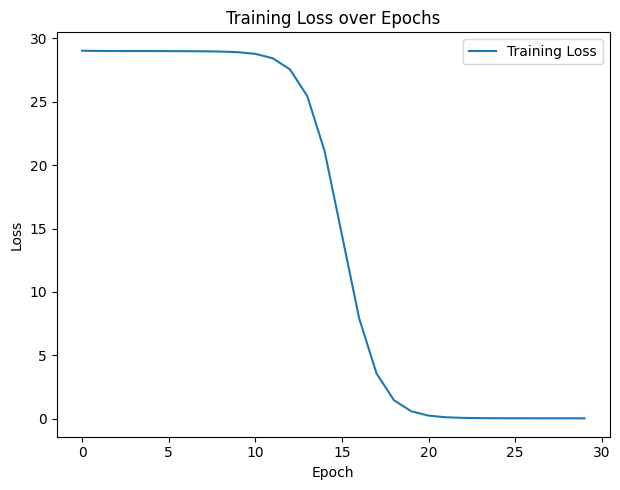

In [ ]:
plt.figure(figsize=(12, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

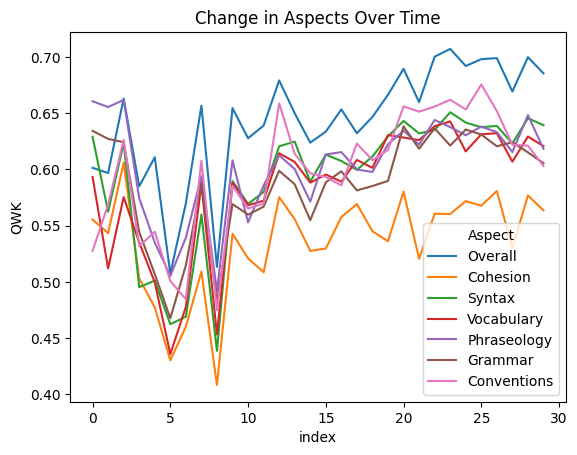

In [ ]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

df = pd.DataFrame(qwk_scores)

df = df.reset_index()

df_melted = df.melt(id_vars=["index"], value_vars=['Overall', 'Cohesion', 'Syntax', 'Vocabulary', 'Phraseology', 'Grammar', 'Conventions'],
                    var_name="Aspect", value_name="QWK")

# Plotting
sns.lineplot(x="index", y="QWK", hue="Aspect", data=df_melted)
plt.title("Change in Aspects Over Time")
plt.show()

In [ ]:
torch.save(model.state_dict(), 'r2bert_w_gen.pth')